In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import load_img, img_to_array
from keras.callbacks import EarlyStopping
from keras.applications import MobileNetV2

import matplotlib.pyplot as plt

# Завантаження даних

Використаємо image_dataset_from_directory, який автоматично:
- читає картинки;
- присвоює мітки на основі назв папок;
- масштабує картинки;
- створює tf.data.Dataset для тренування.

In [2]:
image_size = (256, 256)
batch_size = 32
data_dir = '../../classification/animal/data/'

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    labels="inferred",
    label_mode="int",
    class_names=['cats', 'dogs', 'snakes'],
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    labels="inferred",
    label_mode="int",
    class_names=['cats', 'dogs', 'snakes'],
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=32
)


Found 3000 files belonging to 3 classes.
Using 2400 files for training.
Found 3000 files belonging to 3 classes.
Using 600 files for validation.


In [ ]:
X_train, y_train = [], []
for images, labels in train_ds:
    X_train.append(images.numpy())
    y_train.append(labels.numpy())

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

X_val, y_val = [], []
for images, labels in val_ds:
    X_val.append(images.numpy())
    y_val.append(labels.numpy())

X_val = np.concatenate(X_val)
y_val = np.concatenate(y_val)


2025-05-11 20:52:02.486286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-11 20:52:03.839657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)

X_train: (2400, 256, 256, 3)
y_train: (2400,)
X_val: (600, 256, 256, 3)
y_val: (600,)


In [10]:
train_ds.class_names

['cats', 'dogs', 'snakes']

In [17]:
for images, labels in train_ds.take(1):
    print("Форма images:", images.shape)
    print("Форма labels:", labels.shape)


Форма images: (32, 256, 256, 3)
Форма labels: (32,)


2025-05-12 14:36:14.848786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<!-- https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take -->

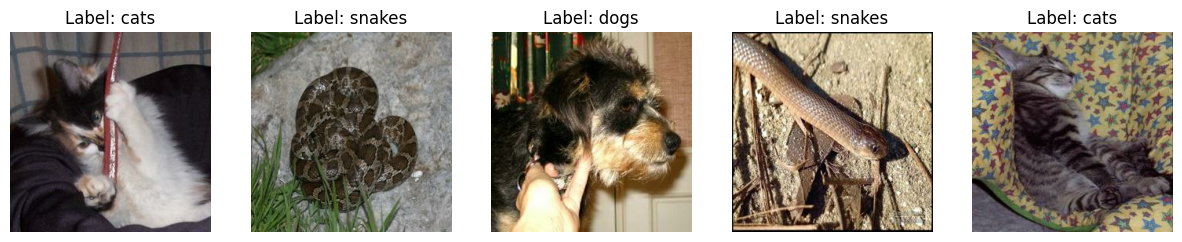

2025-05-12 15:24:28.912350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [29]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    
    for i in range(5):
        axes[i].imshow(images[i].numpy().astype("uint8"))
        axes[i].set_title(f"Label: {train_ds.class_names[labels[i].numpy()]}")
        axes[i].axis("off")

    plt.show()  


In [22]:
def show_batch(dataset, class_names, n=5):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(n * 3, 3))
        for i in range(n):
            ax = plt.subplot(1, n, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label = class_names[labels[i]]
            plt.title(label)
            plt.axis("off")
        plt.tight_layout()
        plt.show()

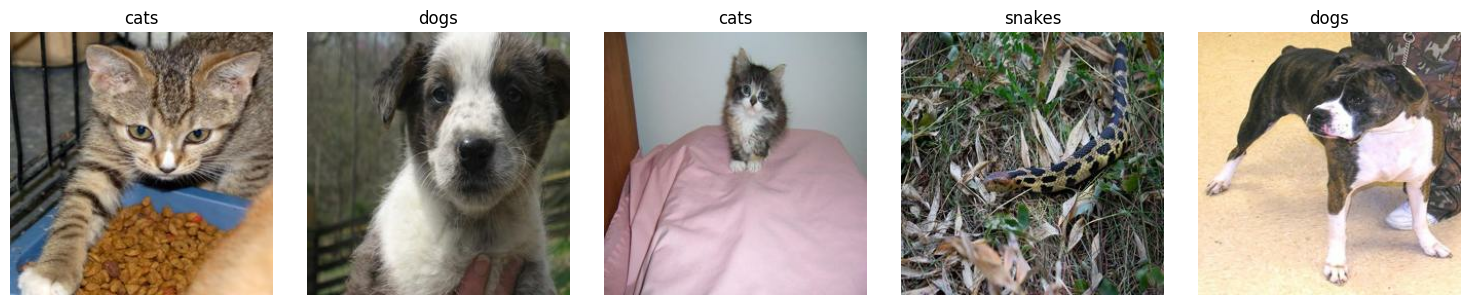

2025-05-12 15:07:32.785073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:
show_batch(train_ds, train_ds.class_names, n=5)

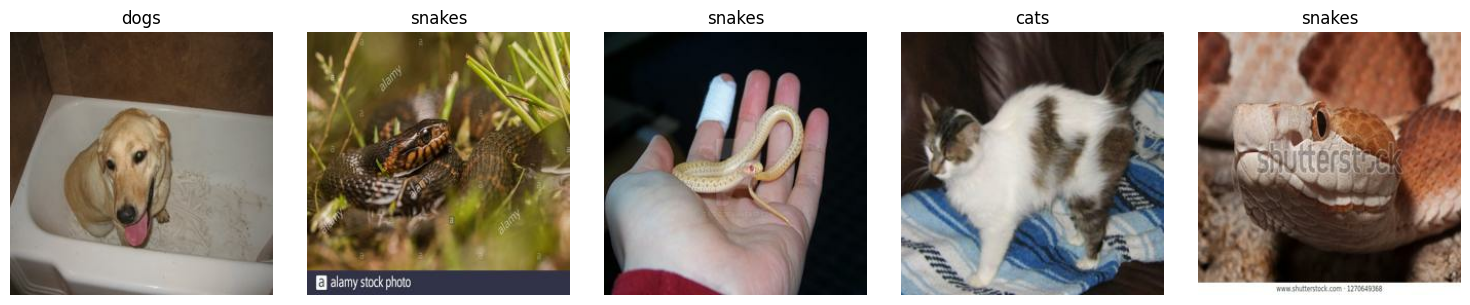

2025-05-12 15:08:01.645250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [24]:
show_batch(val_ds, val_ds.class_names, n=5)

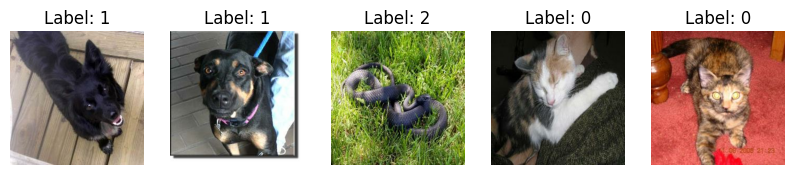

2025-05-12 15:19:07.868331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 5))
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()

# Попередня обробка

TensorFlow автоматично читає зображення у форматі (batch_size, 224, 224, 3) — це 4D тензор. Пікселі — в діапазоні [0, 255], але моделі краще працюють із нормалізованими значеннями. 

In [30]:
X_train = X_train / 255.0

X_val = X_val / 255.0

In [31]:
X_train

array([[[[0.49803922, 0.45882353, 0.4117647 ],
         [0.49803922, 0.45882353, 0.4117647 ],
         [0.49411765, 0.45490196, 0.40784314],
         ...,
         [0.6901961 , 0.69411767, 0.67058825],
         [0.6862745 , 0.6901961 , 0.6666667 ],
         [0.68235296, 0.6862745 , 0.6627451 ]],

        [[0.49411765, 0.45490196, 0.40784314],
         [0.49411765, 0.45490196, 0.40784314],
         [0.49411765, 0.45490196, 0.40784314],
         ...,
         [0.6901961 , 0.69411767, 0.67058825],
         [0.6862745 , 0.6901961 , 0.6666667 ],
         [0.6862745 , 0.6901961 , 0.6666667 ]],

        [[0.49019608, 0.4509804 , 0.40392157],
         [0.49019608, 0.4509804 , 0.40392157],
         [0.49411765, 0.45490196, 0.40784314],
         ...,
         [0.69411767, 0.69803923, 0.6745098 ],
         [0.6901961 , 0.69411767, 0.67058825],
         [0.6862745 , 0.6901961 , 0.6666667 ]],

        ...,

        [[0.4       , 0.3647059 , 0.30588236],
         [0.40392157, 0.36862746, 0.30980393]

In [32]:
X_val

array([[[[0.76862746, 0.8666667 , 0.7411765 ],
         [0.74509805, 0.84313726, 0.7176471 ],
         [0.7058824 , 0.79607844, 0.68235296],
         ...,
         [0.4392157 , 0.44705883, 0.29411766],
         [0.46666667, 0.46666667, 0.31764707],
         [0.53333336, 0.53333336, 0.38431373]],

        [[0.7490196 , 0.85490197, 0.7254902 ],
         [0.7882353 , 0.89411765, 0.7647059 ],
         [0.80784315, 0.90588236, 0.7882353 ],
         ...,
         [0.36078432, 0.36078432, 0.21960784],
         [0.35686275, 0.35686275, 0.21568628],
         [0.38431373, 0.38431373, 0.24313726]],

        [[0.61960787, 0.74509805, 0.6       ],
         [0.73333335, 0.85882354, 0.7137255 ],
         [0.8117647 , 0.92941177, 0.79607844],
         ...,
         [0.38431373, 0.37254903, 0.24313726],
         [0.37254903, 0.36078432, 0.23137255],
         [0.36862746, 0.35686275, 0.22745098]],

        ...,

        [[0.24313726, 0.36862746, 0.18431373],
         [0.3372549 , 0.4509804 , 0.27058825]

# Побудова моделі

In [33]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(256, 256, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3)
])

/Users/mariiasv/Documents/Project/junior-ds-prep/.venv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Компіляція та тренування

In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#  Інференс на нових зображеннях